In [1]:
import sys, os

# add invariant test module
sys.path.append(os.path.abspath(os.path.join('..', 'invariant_test_utils')))

import numpy as np
import pandas as pd
from warfarin_utils.utils import *
import itertools
from sklearn import manifold
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway, kruskal, alexandergovern, levene
from tqdm.auto import tqdm
from warfarin_utils.policy import RandomForestPolicy, LinearPolicy
import random
from sklearn.model_selection import KFold
from warfarin_utils.environment_selection import *
from warfarin_utils.model_selection import *
from invariant_test import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [2]:
# set all the seeds
np.random.seed(0)
random.seed(0)

In [3]:
DMpolicy = LinearPolicy
test_model = LinearRegression()
n_clusters = 4
# choose the experimental setup with non-invariant proxy or without
hidden = True

In [4]:
# load data
optimal_dose = np.load('dataset/therapeut_dose.npy')
X = np.load('dataset/warfarin_relevant.npy')
X_names = np.load('dataset/xnames.npy')
race_info = np.load('dataset/race_info.npy')

envs = X[:, 0]
X = X[:, 1:]
X_names = pd.Series(X_names[1:])

feature_name = ['Race', 'VKORC1', 'BMI', 'Weight', 'Warfarin Treatment', 'CYP2C9', 'Age', 'Enzyme', 'Cardiomyopathy', 
                'Simvastatin']

feature_idx = {name: X_names[X_names.str.lower().str.contains(np.str.lower(name))].index.to_numpy() for name in feature_name}
all_features = np.concatenate(list(feature_idx.values()))

X_names = X_names[all_features].reset_index(drop=True)
X = X[:, all_features]
feature_idx = {name: X_names[X_names.str.lower().str.contains(np.str.lower(name))].index.to_numpy() for name in feature_name}
all_features = np.concatenate(list(feature_idx.values()))

race_df = pd.DataFrame(pd.unique(race_info), columns=['Race'])

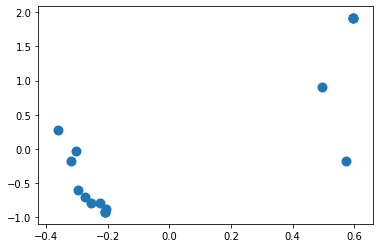

In [5]:
dissim_matrix, env_idx = find_dis_matrix_race(envs, race_info, race_df)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(dissim_matrix).embedding_

plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0, label='MDS')
plt.show()

c:\users\soraw\anaconda3\envs\notears\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


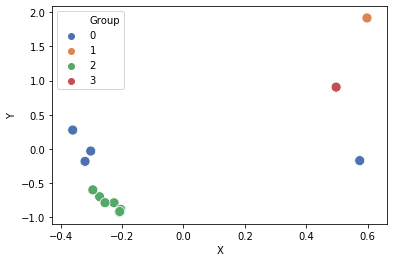

In [6]:
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(dissim_matrix)

cluster_df = pd.DataFrame(data={'X': pos[:, 0], 'Y': pos[:, 1], 'Group':clustering.labels_})

sns.scatterplot(data=cluster_df, x='X', y='Y', s=100, hue='Group', palette="deep")
plt.show()

In [7]:
# create new environments
clusters = dict(enumerate(clustering.labels_))
new_envs = np.array([clusters[env_idx[e]] for e in envs])

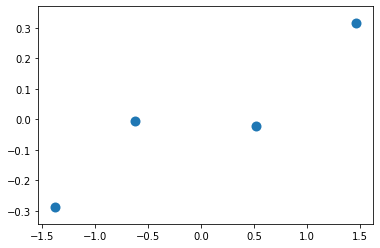

In [8]:
dissim_matrix, env_idx = find_dis_matrix_race(new_envs, race_info, race_df)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dissim_matrix).embedding_

plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0, label='MDS')
plt.show()

In [9]:
pd.Series(new_envs).value_counts()

2    1907
1    1049
0     893
3     115
dtype: int64

In [10]:
env_race = pd.DataFrame(columns=race_df.Race.values)
for e in pd.unique(new_envs):
    env_race = env_race.append(pd.Series(race_info[new_envs==e]).value_counts(), ignore_index=True)
print(env_race.fillna(0))

   White  Unknown  Black or African American   Asian
0   1804       37                       65.0     1.0
1      0        0                        0.0  1049.0
2      0        0                      115.0     0.0
3    392      222                      262.0    17.0


In [11]:
# create all subsets
subsets = create_subsets(feature_idx, min_size=5)
# set E to be new_envs
E = new_envs

# Causal Analysis

In [12]:
context = X[:, X_names[X_names.str.contains('BMI')].index.to_numpy()]
# generate actions
A, init_pi = gen_action_bmi(context, optimal_dose)
    
Y = get_reward(A, optimal_dose)
W = (1/3) / init_pi

rs_m = []
for i in range(20):
    rs_m += [fit_m(A, context, W, n_iter=10)]

rs_m = np.mean(rs_m)

print(rs_m)
rs_rate = rate_fn(pow=1, c=rs_m/X.shape[0])
# rs_rate = rate_fn(pow=1, c=1)

1058.9200984727117


In [13]:
subset_pval = Parallel(n_jobs=20)(
    delayed(invariance_test_actions_resample)(model=test_model, subset=subset, 
                                              X=X, A=A, Y=Y, W=W, E=E, 
                                              rate=rs_rate,n_resample_iter=1)
    for subset in tqdm(subsets.items(), position=0, leave=True))

subset_pval = dict(subset_pval)
subset_pval = pd.Series(index=list(subset_pval.keys()), data=list(subset_pval.values()))

### Get parents

In [14]:
# get intersection of the accepted sets
accepted_sets = [set(s) for s in subset_pval[subset_pval > 0.1].index.str.split("+")]
parents = set.intersection(*accepted_sets)
parents

set()

### Get defining sets

In [15]:
def is_defining_set(candidate_s, accepted_sets):
    return np.all([len(s.intersection(candidate_s)) > 0 for s in accepted_sets])

In [16]:
# sanity check
is_defining_set(parents, accepted_sets) == True

False

In [17]:
def prop_set(candidate_s, accepted_sets):
    return np.mean([len(s.intersection(candidate_s)) > 0 for s in accepted_sets])

In [18]:
all_set = set.union(*accepted_sets)

prop_sets = pd.Series({s: prop_set(set([s]), accepted_sets) for s in all_set})
prop_sets.sort_values(ascending=False)

Race                  0.794189
VKORC1                0.658596
Age                   0.607748
Warfarin Treatment    0.605327
Enzyme                0.593220
CYP2C9                0.588378
BMI                   0.578692
Simvastatin           0.576271
Cardiomyopathy        0.569007
Weight                0.566586
dtype: float64

In [19]:
# take all pairs as candidates
all_pairs = [set(s) for s in itertools.combinations(set.union(*accepted_sets), 2)]
# check whether each pair is a defining set
[pair for pair in all_pairs if is_defining_set(pair, accepted_sets)]

[{'Race', 'VKORC1'}]

## Construct hidden variables

In [20]:
def get_proxy(f_idx, X, optimal_dose, E, e_params=None, noise_std=0.0):
    # fit regression to get coefs
    lr = LinearRegression()
    lr.fit(X, optimal_dose)
    coefs = lr.coef_[f_idx]
    
    # make dependence between coefs and E
    if e_params is None:
        e_params = np.random.uniform(-1, 1, size=(len(pd.unique(E),)))
    coefs = coefs[:, np.newaxis] * e_params[E]
    proxy = np.einsum('ij,ji->i', X[:, f_idx], coefs) + np.random.normal(size=X.shape[0]) * noise_std
    
    return proxy

In [21]:
if hidden:
    hidden_variables = ['CYP2C9', 'VKORC1']

    hidden_idx = np.concatenate([feature_idx[h] for h in hidden_variables])
    e_params = np.array([-2, 2,  3, -4])
    proxy = get_proxy(hidden_idx, X, optimal_dose, E, e_params=e_params)
    new_X = np.hstack([X, proxy[:, np.newaxis]])
    new_X_names = X_names.append(pd.Series({X_names.shape[0]:'Proxy'}))
    new_feature_idx = feature_idx.copy()
    for h in hidden_variables:
        new_feature_idx.pop(h)

    new_feature_idx['Proxy'] = np.array([new_X.shape[1] - 1])
else:
    new_X = X
    new_X_names = X_names
    new_feature_idx = feature_idx.copy()

In [22]:
# recreate all subsets
subsets = create_subsets(new_feature_idx, min_size=5)
all_features = np.concatenate(list(new_feature_idx.values()))

# Generalization Analysis

In [23]:
X = new_X
context = new_X[:, new_X_names[new_X_names.str.contains('BMI') | new_X_names.str.contains('Proxy')].index.to_numpy()]

# generate actions
A, init_pi = gen_action_bmi(context, optimal_dose)
    
Y = get_reward(A, optimal_dose)
W = (1/3) / init_pi

In [24]:
rs_m = []
for i in range(20):
    rs_m += [fit_m(A, context, W, n_iter=10)]

rs_m = np.mean(rs_m)

print(rs_m)
rs_rate = rate_fn(pow=1, c=rs_m/X.shape[0])

2033.9815187085144


In [25]:
subset_pval_E = {}
for e in pd.unique(E):
    X_e, A_e, Y_e, W_e, E_e = new_X[E != e], A[E != e], Y[E != e], W[E != e], E[E != e]
    subset_pval = Parallel(n_jobs=20)(
        delayed(invariance_test_actions_resample)(model=test_model, subset=subset, 
                                                  X=X_e, A=A_e, Y=Y_e, W=W_e, E=E_e, 
                                                  rate=rs_rate,n_resample_iter=3)
        for subset in tqdm(subsets.items(), position=0, leave=True))

    subset_pval = dict(subset_pval)
    subset_pval_E[e] = pd.Series(index=list(subset_pval.keys()), data=list(subset_pval.values()))

In [26]:
best_inv_set_E = {}
best_oracle_set_E = {}
most_predictive_E = {}
predictive_E = {}

oracle_candidates = {k:v for k,v in subsets.items() if 'Proxy' not in k}
for e in pd.unique(E):
    X_e, A_e, Y_e, init_pi_e = X[E != e], A[E != e], Y[E != e], init_pi[E != e]
    top_inv_sets = subset_pval_E[e].sort_values(ascending=False).iloc[:20].to_dict()
    
    top_inv_rewards = find_opitmal_set(X_e, A_e, Y_e, init_pi_e, 
                                       DMpolicy=DMpolicy,
                                       candidate_subsets=top_inv_sets,
                                       subsets=subsets)
    
    top_oracle_rewards = find_opitmal_set(X_e, A_e, Y_e, init_pi_e, 
                                       DMpolicy=DMpolicy,
                                       candidate_subsets=oracle_candidates,
                                       subsets=subsets)
    
    most_predictive = find_opitmal_set(X_e, A_e, Y_e, init_pi_e, 
                                       DMpolicy=DMpolicy,
                                       candidate_subsets=subsets,
                                       subsets=subsets)
    
    best_inv_set_E[e] = top_inv_rewards.sort_values(ascending=False)[:3]
    best_oracle_set_E[e] = top_oracle_rewards.sort_values(ascending=False)[:3]
    most_predictive_E[e] = most_predictive.sort_values(ascending=False)[:3]
    predictive_E[e] = most_predictive

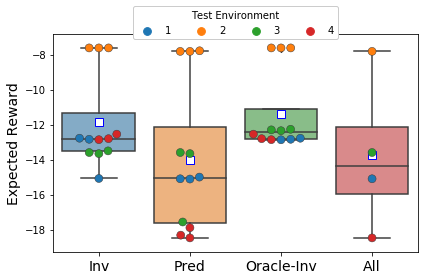

In [27]:
best_inv_can = [k for k in subsets.keys() if (len(k.split('+')) == (len(new_feature_idx) - 1)) and (not 'Proxy' in k)]
candidate_subsets_E = {}
for e in pd.unique(E):
    inv_candidates = {'Inv_'+k:subsets[k] for k in best_inv_set_E[e].keys()}
    best_inv_candidates = {'Oracle-Inv_'+k:subsets[k] for k in best_oracle_set_E[e].keys()}
    predictive_candidates = {'Pred_'+k:subsets[k] for k in most_predictive_E[e].keys()}
    
    # combine dict
    if hidden:
        candidate_subsets_E[e] = {**inv_candidates, **predictive_candidates, **best_inv_candidates,
                                  **{'All_'+list(subsets.keys())[-1]:subsets[list(subsets.keys())[-1]]}}
    else:
        candidate_subsets_E[e] = {**inv_candidates, **predictive_candidates, **{'All_'+list(subsets.keys())[-1]:subsets[list(subsets.keys())[-1]]}}
    
reward_df = get_test_rewards_E(X, A, Y, E, 
                               optimal_dose,
                               init_pi, 
                               DMpolicy=DMpolicy, 
                               candidate_subsets=candidate_subsets_E)

# reindex test envs
reward_df['test_env'] += 1

reward_df['subset_type'] = reward_df.subset.str.split("_").map(lambda x: x[0])

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=reward_df, x='subset_type', y='reward', whis=2, showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":8})

ax.set_xticklabels(ax.get_xticks(), size = 14)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

ax = sns.swarmplot(data=reward_df, x='subset_type', y='reward', hue='test_env', 
                   size=8, linewidth=0.5)
ax.legend_.remove()

# Put the legend out of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=4, fancybox=True, title='Test Environment', framealpha=1.)
plt.xlabel("", size=14)
plt.ylabel("Expected Reward", size=14)
plt.tight_layout()
plt.savefig('results/warfarin_hidden_{}.pdf'.format(hidden))


# Correlation Between P-value and Generalization

In [28]:
reward_df_all = get_test_rewards(X, A, Y, E, 
                                 optimal_dose,
                                 init_pi, 
                                 DMpolicy=DMpolicy, 
                                 candidate_subsets=subsets)

In [89]:
pval_df = pd.DataFrame(columns=['subset', 'p-value', 'predictiveness'])
for e in pd.unique(E):
    pval_df_e = pd.DataFrame(subset_pval_E[e], columns=['p-value']).reset_index().rename(columns={"index":"subset"})
    predictive_df_e = pd.DataFrame(predictive_E[e], columns=['Predictiveness']).reset_index().rename(columns={"index":"subset"})
    predictive_df_e['Predictiveness'] = pd.cut(predictive_df_e['Predictiveness'], bins=4, labels=[1, 2, 3, 4])
    final_df_e = pval_df_e.merge(predictive_df_e, on='subset')
    final_df_e['test_env'] = int(e)
    pval_df = pval_df.append(final_df_e, ignore_index=True)

pval_df['Log P-value'] = np.log(pval_df['p-value'])
reward_pval_df = reward_df_all.merge(pval_df, on=['subset', 'test_env'])
reward_pval_df = reward_pval_df.rename(columns={'test_env':'Test Environment', 'reward': 'Expected Reward'})
reward_pval_df['Test Environment'] += 1

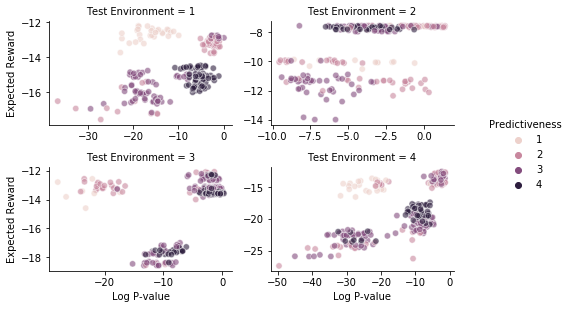

In [167]:
g = sns.relplot(
    data=reward_pval_df, x="Log P-value", y="Expected Reward",
    col="Test Environment", col_wrap= 2, hue="Predictiveness",
    kind="scatter", s=40, alpha=0.6, facet_kws={'sharey': False, 'sharex': False},
    height=2.2, aspect=1.5
)
c = g._legend.get_children()[0].get_children()[1].get_children()[0]
c._children = c._children[1:]
g._legend.set_title("Predictiveness")
plt.savefig('results/p-value_analysis.pdf')